In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import os 
import tabulate
from scipy.stats import wilcoxon, ttest_rel

from slim_gsgp_lib.datasets.data_loader import *
datasets = [globals()[i] for i in globals() if 'load' in i][2:]

In [26]:
dataset_names=[]
for file in os.listdir('results/slim'):
    if 'scaled_xo_mutxo_strucmut' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_name = file.split('_scaled')[0]
        dataset_names.append(dataset_name)

for dataset in dataset_names:
    dict_params = {}
    # dict_results = {}
    
    for suffix in ['MUL_ABS', 'MUL_SIG1', 'MUL_SIG2', 'SUM_ABS', 'SUM_SIG1', 'SUM_SIG2']:
        params = pickle.load(open(f'params/{dataset}_SLIM_{suffix}_scaled_new.pkl', 'rb'))
        dict_params.update(params)
        # results = pickle.load(open(f'results/slim/{dataset}_SLIM_{suffix}_scaled_strucmut_new_m3.pkl', 'rb'))
        # for k, v in results.items():
        #     if k not in dict_results:
        #         dict_results[k] = {}
        #     dict_results[k].update(v)
            
        # Delete the loaded pickle files 
        os.remove(f'params/{dataset}_SLIM_{suffix}_scaled_new.pkl')
        # os.remove(f'results/slim/{dataset}_SLIM_{suffix}_scaled_strucmut_new_m3.pkl')
    
    # Dump the results 
    pickle.dump(dict_params, open(f'params/{dataset}_scaled_new_m3.pkl', 'wb'))
    # pickle.dump(dict_results, open(f'results/slim/{dataset}_scaled_strucmut_new_m3.pkl', 'wb'))

#### Found 
- Ms upper of 0
- Parkinson dataset too large (> 5000 samples)

#### TODO
- Make plots for the results to check how the fitness evolves with time (train/test) + diversity with callbacks

## FUNCTIONS

In [8]:
dataset_names=[]
count = 0
for file in os.listdir('results/slim'):
    count += 1
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_name = file.split('_scaled')[0]
        dataset_names.append(dataset_name)
    
print(f'Number of datapoints: {count}')
    
num_existing = {'unscaled':0, 'unscaled_mutxo':0, 'scaled_mutxo':0, 'scaled_mutxo_strucmut':0, 
                'scaled_xo_strucmut':0, 'scaled_xo_mutxo_strucmut':0, 'scaled_xo':0, 'scaled':0, 'scaled_strucmut':0}
for dataset_name in dataset_names:
    for key in num_existing.keys():
        if os.path.exists(f'results/slim/{dataset_name}_{key}.pkl'):
            num_existing[key]+=1
        
        if 'unscaled_mutxo' in key: 
            if os.path.exists(f'results/slim/{dataset_name}_mutxo.pkl'):
                num_existing[key]+=1
            
        elif 'unscaled' in key:
            if os.path.exists(f'results/slim/{dataset_name}.pkl'):
                num_existing[key]+=1
            
num_existing

Number of datapoints: 212


{'unscaled': 15,
 'unscaled_mutxo': 15,
 'scaled_mutxo': 16,
 'scaled_mutxo_strucmut': 15,
 'scaled_xo_strucmut': 15,
 'scaled_xo_mutxo_strucmut': 15,
 'scaled_xo': 15,
 'scaled': 15,
 'scaled_strucmut': 15}

In [9]:
def get_significance(p_value, ratio):
    if p_value >= 0.05:
        return '0'
    elif ratio > 1:
        return '-' * (1 + int(p_value < 0.01) + int(p_value < 0.001))
    else:
        return '+' * (1 + int(p_value < 0.01) + int(p_value < 0.001))

def calculate_statistical_significance(prefix1, prefix2, dataset_names):
    df_stat_sign = pd.DataFrame(columns=['Dataset', 'Algorithm', 'Ratio', 'Significance_RMSE', 'Significance_Size'])
    df_stat_sign = df_stat_sign.astype({'Dataset': 'object', 'Algorithm': 'object', 'Ratio': 'float64', 'Significance_RMSE': 'object', 'Significance_Size': 'object'})

    for dataset in dataset_names:
        path_1 = f'results/slim/{dataset}_{prefix1}.pkl' if prefix1 != '' else f'results/slim/{dataset}.pkl'
        path_2 = f'results/slim/{dataset}_{prefix2}.pkl' if prefix2 != '' else f'results/slim/{dataset}.pkl'
        try: 
            with open(path_1, 'rb') as f:
                results_1 = pickle.load(f)
            
            with open(path_2, 'rb') as f:
                results_2 = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue        
        
        rmse_1 = results_1['rmse_compare']
        rmse_2 = results_2['rmse_compare']
        size_1 = results_1['size']
        size_2 = results_2['size']
        
        for algorithm in rmse_1.keys():
            rmse_1_values = rmse_1[algorithm]
            rmse_2_values = rmse_2[algorithm]
            size_1_values = size_1[algorithm]
            size_2_values = size_2[algorithm]
            
            # Wilcoxon-Test durchführen
            d_rmse = np.round(np.array(rmse_1_values) - np.array(rmse_2_values), decimals=8)
            d_size = np.round(np.array(size_1_values) - np.array(size_2_values), decimals=8)
            
            statistic, p_value = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
            statistic_size, p_value_size = wilcoxon(d_size, zero_method='pratt', alternative='two-sided', method='approx')
            
            rmse_1_mean = np.mean(rmse_1_values)
            rmse_2_mean = np.mean(rmse_2_values)
            ratio = rmse_1_mean / rmse_2_mean
            
            significance = get_significance(p_value, ratio)
            
            significance_size = get_significance(p_value_size, np.mean(size_1_values) / np.mean(size_2_values))
            
            new_row = pd.DataFrame({
                'Dataset': [dataset],
                'Algorithm': [algorithm],
                'Ratio': [ratio],  
                'Significance_RMSE': [significance],
                'Significance_Size': [significance_size]
            })

            df_stat_sign = pd.concat([df_stat_sign, new_row], ignore_index=True)

    # DataFrame für bessere Lesbarkeit sortieren
    df_stat_sign = df_stat_sign.sort_values(['Dataset', 'Algorithm'])
    df_stat_sign.set_index(['Dataset', 'Algorithm'], inplace=True)

    return df_stat_sign

def calculate_statistical_significance_best(prefix1, prefix2, dataset_names):
    df_stat_sign = pd.DataFrame(columns=['Dataset', 'Algorithm_1', 'Algorithm_2', 'Ratio', 'Significance_RMSE', 'Significance_Size'])
    df_stat_sign = df_stat_sign.astype({'Dataset': 'object', 'Algorithm_1': 'object', 'Algorithm_2': 'object', 'Ratio': 'float64', 'Significance_RMSE': 'object', 'Significance_Size': 'object'})

    for dataset in dataset_names:
        path_1 = f'results/slim/{dataset}_{prefix1}.pkl' if prefix1 != '' else f'results/slim/{dataset}.pkl'
        path_2 = f'results/slim/{dataset}_{prefix2}.pkl' if prefix2 != '' else f'results/slim/{dataset}.pkl'
        try: 
            with open(path_1, 'rb') as f:
                results_1 = pickle.load(f)
            
            with open(path_2, 'rb') as f:
                results_2 = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue        
        
        rmse_1 = results_1['rmse_compare']
        rmse_2 = results_2['rmse_compare']
        size_1 = results_1['size']
        size_2 = results_2['size']
        
        # Find best algorithm for each prefix
        best_algo_1 = min(rmse_1, key=lambda k: np.mean(rmse_1[k]))
        best_algo_2 = min(rmse_2, key=lambda k: np.mean(rmse_2[k]))
        
        rmse_1_values = rmse_1[best_algo_1]
        rmse_2_values = rmse_2[best_algo_2]
        size_1_values = size_1[best_algo_1]
        size_2_values = size_2[best_algo_2]
        
        # Wilcoxon-Test durchführen
        d_rmse = np.round(np.array(rmse_1_values) - np.array(rmse_2_values), decimals=8)
        d_size = np.round(np.array(size_1_values) - np.array(size_2_values), decimals=8)
        
        statistic, p_value = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
        statistic_size, p_value_size = wilcoxon(d_size, zero_method='pratt', alternative='two-sided', method='approx')
        
        rmse_1_mean = np.mean(rmse_1_values)
        rmse_2_mean = np.mean(rmse_2_values)
        ratio = rmse_1_mean / rmse_2_mean
        
        significance = get_significance(p_value, ratio)
        significance_size = get_significance(p_value_size, np.mean(size_1_values) / np.mean(size_2_values))
        
        new_row = pd.DataFrame({
            'Dataset': [dataset],
            'Algorithm_1': [best_algo_1],
            'Algorithm_2': [best_algo_2],
            'Ratio': [ratio],  
            'Significance_RMSE': [significance],
            'Significance_Size': [significance_size]
        })

        df_stat_sign = pd.concat([df_stat_sign, new_row], ignore_index=True)

    # DataFrame für bessere Lesbarkeit sortieren
    df_stat_sign = df_stat_sign.sort_values(['Dataset'])
    df_stat_sign.set_index('Dataset', inplace=True)

    return df_stat_sign

In [10]:
def compare_prefixes(main_prefix, prefix_list, dataset_names):
    rmse_df = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_names, ['SLIM+SIG2', 'SLIM*SIG2', 'SLIM+ABS', 'SLIM*ABS', 'SLIM+SIG1', 'SLIM*SIG1']], names=['Dataset', 'Algorithm']), columns=prefix_list)
    size_df = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_names, ['SLIM+SIG2', 'SLIM*SIG2', 'SLIM+ABS', 'SLIM*ABS', 'SLIM+SIG1', 'SLIM*SIG1']], names=['Dataset', 'Algorithm']), columns=prefix_list)

    for dataset in dataset_names:
        main_path = f'results/slim/{dataset}_{main_prefix}.pkl' if main_prefix != '' else f'results/slim/{dataset}.pkl'
        try:
            with open(main_path, 'rb') as f:
                main_results = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue

        main_rmse = main_results['rmse_compare']
        main_size = main_results['size']
        
        for prefix in prefix_list:
            if prefix == main_prefix:
                rmse_df.loc[dataset, prefix] = '0'
                size_df.loc[dataset, prefix] = '0'
                continue
            
            comp_path = f'results/slim/{dataset}_{prefix}.pkl' if prefix != '' else f'results/slim/{dataset}.pkl'
            try:
                with open(comp_path, 'rb') as f:
                    comp_results = pickle.load(f)
            except FileNotFoundError:
                print(f'Dataset nicht verfügbar: {dataset}')
                continue

            comp_rmse = comp_results['rmse_compare']
            comp_size = comp_results['size']

            for algorithm in main_rmse.keys():
                main_rmse_values = main_rmse[algorithm]
                main_size_values = main_size[algorithm]
                comp_rmse_values = comp_rmse[algorithm]
                comp_size_values = comp_size[algorithm]

                # RMSE comparison
                d_rmse = np.round(np.array(main_rmse_values) - np.array(comp_rmse_values), decimals=8)
                _, p_value_rmse = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
                
                rmse_ratio = np.mean(comp_rmse_values) / np.mean(main_rmse_values)
                rmse_significance = get_significance(p_value_rmse, rmse_ratio)
                
                rmse_df.loc[(dataset, algorithm), prefix] = rmse_significance

                # Size comparison
                d_size = np.round(np.array(main_size_values) - np.array(comp_size_values), decimals=8)
                _, p_value_size = wilcoxon(d_size, zero_method='pratt', alternative='two-sided', method='approx')
                
                size_ratio = np.mean(main_size_values) / np.mean(comp_size_values)
                size_significance = get_significance(p_value_size, size_ratio)
                                
                size_df.loc[(dataset, algorithm), prefix] = size_significance

    # Remove rows with NaN values
    rmse_df = rmse_df.dropna()
    size_df = size_df.dropna()
    return rmse_df, size_df

In [11]:
def create_rmse_means_dataset(prefixes, dataset_names, ignore_errors=True):
    df = pd.DataFrame()
    available_datasets = []

    for prefix in prefixes:
        for dataset in dataset_names:
            file_path = f'results/slim/{dataset}_{prefix}.pkl' if prefix else f'results/slim/{dataset}.pkl'
            
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}") if not ignore_errors else None
                continue

            with open(file_path, 'rb') as f:
                results = pickle.load(f)

            rmse_compare = results['rmse_compare']

            for algorithm, rmse_values in rmse_compare.items():
                rmse_mean = np.mean(rmse_values)
                
                new_row = pd.DataFrame({
                    'Prefix': [prefix if prefix else 'base'],
                    'Algorithm': [algorithm],
                    dataset: [rmse_mean]
                })

                df = pd.concat([df, new_row], ignore_index=True)
            
            if dataset not in available_datasets:
                available_datasets.append(dataset)

    # Pivot the DataFrame using only available datasets
    df_pivot = df.pivot_table(values=available_datasets, index=['Prefix', 'Algorithm'], aggfunc='first')
    
    # Remove columns with NaN values
    df_pivot = df_pivot.dropna(axis=1)

    return df_pivot

## Scale vs non-scale

#### Ratio of the minimum means

In [31]:
dataset_names=[]
df_ratio = pd.DataFrame()
data_mins = []
for file in os.listdir('results/slim'):
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_name = file.split('_scaled')[0]
        dataset_names.append(dataset_name)

for dataset in dataset_names:
    try: 
        with open('results/slim/'+dataset+'_scaled_new_m3.pkl', 'rb') as f:
            results_scaled = pickle.load(f)
        
        with open('results/slim/'+dataset+'.pkl', 'rb') as f:
            results_unscaled = pickle.load(f)
    except:
        print('Dataset not available:', dataset)
        continue        
    
    # Get the dataset 
    X, y = [i for i in datasets if dataset in i.__name__][0]()
    # Get the scale of the dataset
    scale = pd.DataFrame(X).mean()
    scale_X = scale.mean()
    scale_y = y.mean().item()
    scale_diff = np.abs(np.log(0.0001+(scale_X/scale_y)))
    scale_std = scale.std()
    
    rmse_scaled = results_scaled['rmse_compare']
    rmse_unscaled = results_unscaled['rmse_compare']
       
    rmse_scaled_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_scaled.items()])
    rmse_unscaled_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_unscaled.items()])

    rmse_ratio = rmse_scaled_means/rmse_unscaled_means
    rmse_ratio_min = rmse_scaled_means.min()/rmse_unscaled_means.min()
    
    df_ratio_temp = pd.DataFrame(rmse_ratio, columns=[dataset])
    df_ratio = pd.concat([df_ratio, df_ratio_temp], axis=1)
    data_mins.append((dataset, rmse_ratio_min, scale_diff, scale_std))
    
# Change the index to results_scaled['rmse_compare'].keys()
df_ratio.index = list(results_scaled['rmse_compare'].keys())
df_mins = pd.DataFrame(data_mins, columns=['Dataset', 'Min ratio', 'Scale diff', 'Scale std'])
df_mins.set_index('Dataset', inplace=True)

Dataset not available: parkinson_updrs


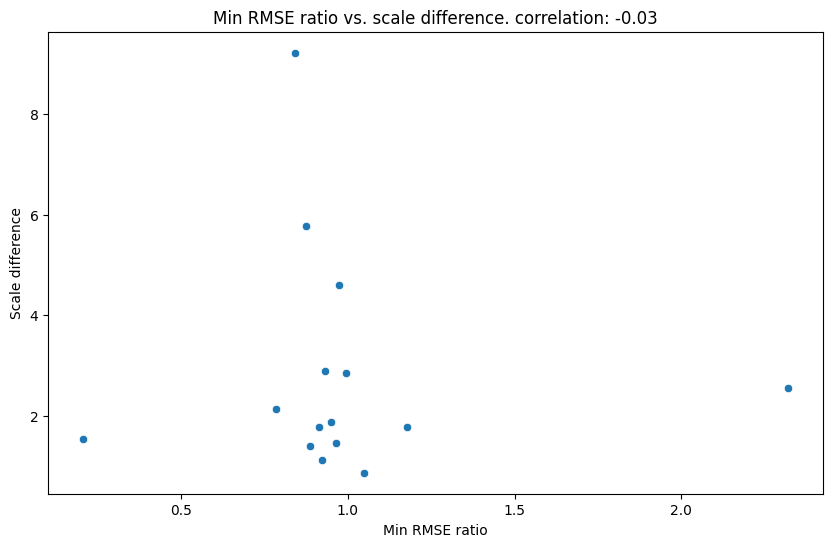

In [34]:
# Scatter plot of the ratio of scaled to unscaled RMSE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mins, x='Min ratio', y='Scale diff')
plt.ylabel('Scale difference')
plt.xlabel('Min RMSE ratio')
plt.title(f'Min RMSE ratio vs. scale difference. correlation: {df_mins.corr().iloc[0, 1]:.2f}')
plt.show()

In [35]:
df_ratio

,airfoil,bike_sharing,bioav,boston,breast_cancer,concrete_slump,concrete_strength,diabetes,efficiency_cooling,efficiency_heating,forest_fires,istanbul,ld50,ppb,resid_build_sale_price
SLIM*ABS,0.131421,0.827911,0.574213,0.729988,1.061175,0.781003,0.346037,0.391596,0.725923,0.503197,0.965748,1.031880,2.070598,1.130794,0.431678
SLIM*SIG1,0.198188,0.711707,0.842568,1.062110,1.260000,0.940834,0.671212,0.789507,1.248200,1.377017,1.138160,0.944918,1.033630,1.199278,0.877149
SLIM*SIG2,0.113397,0.582322,0.696149,0.652133,1.010715,0.871979,0.519251,0.385990,0.587756,0.669248,0.673916,1.050462,2.795777,0.986751,0.520875
SLIM+ABS,0.244397,1.866971,0.896702,1.121260,0.957998,0.930518,0.620154,0.826396,1.113130,0.993588,0.867437,1.083084,0.991656,1.151294,1.172285
SLIM+SIG1,0.109734,0.488327,0.707811,0.655146,1.005876,0.895178,0.449162,0.396648,0.614124,0.678350,1.002295,1.068592,0.913669,1.071200,0.671016
SLIM+SIG2,0.178814,2.872323,0.952036,0.900279,0.922153,0.897284,0.795027,0.855677,0.912059,0.917112,0.999727,0.989886,0.856181,1.229532,1.004265


In [36]:
df_mins

,Min ratio,Scale diff,Scale std
Dataset,,,
airfoil,0.206443,1.551166,1.284542e+03
bike_sharing,2.320320,2.560018,1.021231e+03
bioav,0.886937,1.413954,1.527147e+02
boston,0.923789,1.134611,1.401351e+02
breast_cancer,0.974215,4.591516,1.958614e+02
concrete_slump,0.930518,2.895665,3.420191e+02
concrete_strength,0.784093,2.135987,3.694190e+02
diabetes,0.842180,9.210340,1.490846e-10
efficiency_cooling,0.912059,1.791065,2.420173e+02


#### Statistical significance

In [40]:
calculate_statistical_significance_best('scaled_new_m3', '', dataset_names).sort_values('Ratio')

Dataset nicht verfügbar: parkinson_updrs


,Algorithm_1,Algorithm_2,Ratio,Significance_RMSE,Significance_Size
Dataset,,,,,
airfoil,SLIM+SIG2,SLIM*ABS,0.206443,+++,---
concrete_strength,SLIM+SIG1,SLIM*SIG1,0.784093,+++,+++
diabetes,SLIM+SIG1,SLIM*SIG1,0.842180,+++,+++
resid_build_sale_price,SLIM*ABS,SLIM*ABS,0.874094,++,0
bioav,SLIM*ABS,SLIM*SIG1,0.886937,+++,+++
efficiency_cooling,SLIM+SIG2,SLIM*SIG1,0.912059,+++,+++
boston,SLIM+SIG1,SLIM*ABS,0.923789,+,---
concrete_slump,SLIM+ABS,SLIM*ABS,0.930518,++,+++
efficiency_heating,SLIM+SIG2,SLIM*ABS,0.950041,+,---


In [479]:
df_stat_sign = calculate_statistical_significance('scaled', '', dataset_names)
print(df_stat_sign['Significance_RMSE'].value_counts())
print(df_stat_sign['Significance_Size'].value_counts())

Dataset nicht verfügbar: parkinson_updrs
Significance_RMSE
+++    45
0      17
---    14
+       4
--      4
-       3
++      3
Name: count, dtype: int64
Significance_Size
+++    50
---    23
0       9
-       3
+       2
++      2
--      1
Name: count, dtype: int64


In [480]:
df_stat_sign[['Ratio', 'Significance_RMSE']].head(20)

Ratio Significance_RMSE
Dataset      Algorithm                            
airfoil      SLIM*ABS   0.250768               +++
             SLIM*SIG1  0.258100               +++
             SLIM*SIG2  0.219730               +++
             SLIM+ABS   0.118064               +++
             SLIM+SIG1  0.107271               +++
             SLIM+SIG2  0.120323               +++
bike_sharing SLIM*ABS   2.163475               ---
             SLIM*SIG1  2.870549               ---
             SLIM*SIG2  0.873238                 0
             SLIM+ABS   0.655430               +++
             SLIM+SIG1  0.455317               +++
             SLIM+SIG2  0.850235                 +
bioav        SLIM*ABS   0.881227               +++
             SLIM*SIG1  0.900988               +++
             SLIM*SIG2  0.852894               +++
             SLIM+ABS   0.693199               +++
             SLIM+SIG1  0.702940               +++
             SLIM+SIG2  0.619006               +++
boston       SLIM*ABS   1.131885                 -
             SLIM*SIG1  1.123700                 -

#### Deeper dive into the data

In [5]:
dataset_names = []
algorithms = []
data = []

for file in os.listdir('results/slim'):
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_names.append(file.split('_scaled')[0])

for dataset in dataset_names:
    try:
        with open(f'results/slim/{dataset}_scaled_new_m3.pkl', 'rb') as f:
            results_scaled = pickle.load(f)
        
        with open(f'results/slim/{dataset}.pkl', 'rb') as f:
            results_unscaled = pickle.load(f)
    except:
        print('Dataset nicht verfügbar:', dataset)
        continue

    if not algorithms:
        algorithms = list(results_scaled['rmse_compare'].keys())
        
    # Get the dataset 
    X, y = [i for i in datasets if dataset in i.__name__][0]()
    # Get the scale of the dataset
    scale = pd.DataFrame(X).mean()
    scale_X = scale.mean()
    scale_y = y.mean().item()
    scale_diff = (scale_X/scale_y)
    scale_std = scale.std()

    rmse_scaled = results_scaled['rmse_compare']
    rmse_unscaled = results_unscaled['rmse_compare']
    size_scaled = results_scaled['size']
    size_unscaled = results_unscaled['size']
    train_fit_scaled = results_scaled['train_fit']
    train_fit_unscaled = results_unscaled['train_fit']
    test_fit_scaled = results_scaled['test_fit']
    test_fit_unscaled = results_unscaled['test_fit']

    for algo in algorithms:
        rmse_scaled_mean = np.mean(rmse_scaled[algo])
        rmse_unscaled_mean = np.mean(rmse_unscaled[algo])
        rmse_ratio = rmse_scaled_mean/rmse_unscaled_mean
        size_scaled_mean = np.mean(size_scaled[algo])
        size_unscaled_mean = np.mean(size_unscaled[algo])
        data.append((dataset, algo, rmse_scaled_mean, rmse_unscaled_mean, rmse_ratio, size_scaled_mean, size_unscaled_mean, scale_diff, scale_std, scale_X, scale_y))

df = pd.DataFrame(data, columns=['Dataset', 'Algorithm', 'RMSE_Scaled', 'RMSE_Unscaled', 'RMSE_Ratio', 'Size_Scaled', 'Size_Unscaled', 'Scale_Diff', 'Scale_Std', 'Scale_X', 'Scale_Y'])
df_pivot = df.set_index(['Dataset', 'Algorithm'])

df_pivot = df_pivot.sort_index()

Dataset nicht verfügbar: parkinson_updrs


In [11]:
df_pivot

RMSE_Scaled  RMSE_Unscaled  RMSE_Ratio  \
Dataset                Algorithm                                           
airfoil                SLIM*ABS      5.381662      22.802041    0.236017   
                       SLIM*SIG1     5.213681      26.325328    0.198048   
                       SLIM*SIG2     5.198071      26.306740    0.197595   
                       SLIM+ABS      5.572750      45.839444    0.121571   
                       SLIM+SIG1     4.786641      43.620311    0.109734   
...                                       ...            ...         ...   
resid_build_sale_price SLIM*SIG1    69.588303      79.026454    0.880570   
                       SLIM*SIG2    70.824690      79.334629    0.892734   
                       SLIM+ABS     81.822933     135.972465    0.601761   
                       SLIM+SIG1    82.441351     122.860398    0.671016   
                       SLIM+SIG2    79.363519     141.331747    0.561541   

                                  Size_Scaled  Size_Unscaled  Scale_Diff  \
Dataset                Algorithm                                           
airfoil                SLIM*ABS        222.84         171.12    4.716865   
                       SLIM*SIG1       268.04         203.08    4.716865   
                       SLIM*SIG2       359.42         268.20    4.716865   
                       SLIM+ABS        148.66         416.82    4.716865   
                       SLIM+SIG1       163.68         317.34    4.716865   
...                                       ...            ...         ...   
resid_build_sale_price SLIM*SIG1       177.10         208.30  319.705139   
                       SLIM*SIG2       323.78         498.28  319.705139   
                       SLIM+ABS        148.40         333.86  319.705139   
                       SLIM+SIG1        60.78         273.74  319.705139   
                       SLIM+SIG2       225.84         495.74  319.705139   

                                     Scale_Std       Scale_X     Scale_Y  
Dataset                Algorithm                                          
airfoil                SLIM*ABS     1284.54248    588.834290  124.835953  
                       SLIM*SIG1    1284.54248    588.834290  124.835953  
                       SLIM*SIG2    1284.54248    588.834290  124.835953  
                       SLIM+ABS     1284.54248    588.834290  124.835953  
                       SLIM+SIG1    1284.54248    588.834290  124.835953  
...                                        ...           ...         ...  
resid_build_sale_price SLIM*SIG1  229153.87500  74378.710938  232.647842  
                       SLIM*SIG2  229153.87500  74378.710938  232.647842  
                       SLIM+ABS   229153.87500  74378.710938  232.647842  
                       SLIM+SIG1  229153.87500  74378.710938  232.647842  
                       SLIM+SIG2  229153.87500  74378.710938  232.647842  

[90 rows x 9 columns]

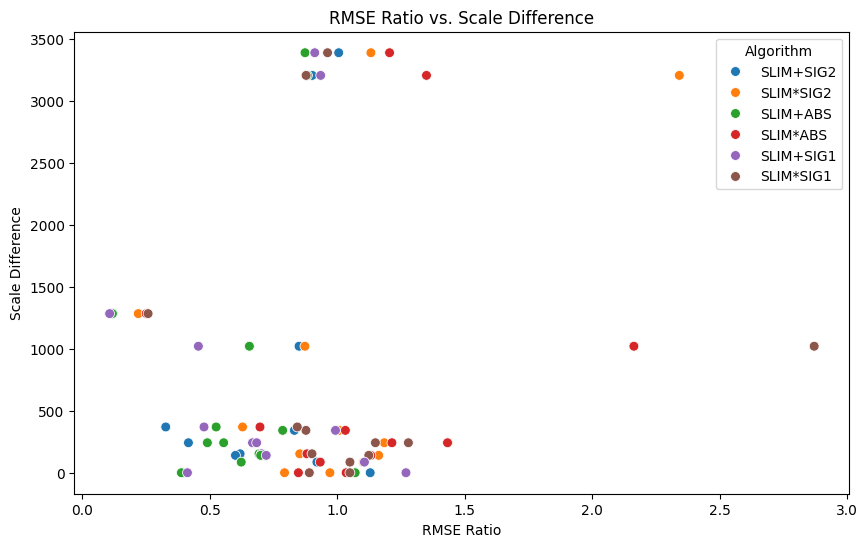

In [191]:
# Scatterplot the RMSE ratio against the scale difference
plt.figure(figsize=(10,6))
sns.scatterplot(data=df[df['Scale_Diff']<50], x='RMSE_Ratio', y='Scale_Std', hue='Algorithm', s=50)
plt.title('RMSE Ratio vs. Scale Difference')
plt.xlabel('RMSE Ratio')
plt.ylabel('Scale Difference')
plt.show()

#### Parameter comparison

In [30]:
def create_param_diff_df(dataset_names):
    all_params = []
    all_algorithms = set()

    for dataset in dataset_names:
        try:
            with open(f'params/{dataset}_scaled_new_m3.pkl', 'rb') as f:
                params_scaled = pickle.load(f)
            
            with open(f'params/{dataset}.pkl', 'rb') as f:
                params_unscaled = pickle.load(f)
        except FileNotFoundError:
            print(f'Dataset nicht verfügbar: {dataset}')
            continue

        all_algorithms.update(params_scaled.keys())

        for algo in params_unscaled.keys():
            for param, value_unscaled in params_unscaled[algo].items():
                value_scaled = params_scaled[algo][param]
                all_params.append({
                    'Dataset': dataset,
                    'Algorithm': algo,
                    'Parameter': param,
                    'Scaled': value_scaled,
                    'Unscaled': value_unscaled,
                    'Difference': value_scaled - value_unscaled
                })

    df = pd.DataFrame(all_params)
    return df, list(all_algorithms)

# Funktion zur Formatierung der Unterschiede
def format_diff(x):
    return f"{x:+.2f}" if isinstance(x, (int, float)) else str(x)

# Erstellen des DataFrames
dataset_names = ['bike_sharing']
df, algorithms = create_param_diff_df(dataset_names)
df = df[~((df['Scaled'] == 0) & (df['Unscaled'] == 0))]

# Für jeden Datensatz und Algorithmus die Unterschiede anzeigen
for dataset in df['Dataset'].unique():
    print(f"\n## {dataset}")
    for algo in algorithms:
        print(f"\n**{algo}**")
        subset = df[(df['Dataset'] == dataset) & (df['Algorithm'] == algo)]
        if not subset.empty:
            diff_table = subset[['Parameter', 'Scaled', 'Unscaled', 'Difference']].copy()
            diff_table['Difference'] = diff_table['Difference'].apply(format_diff)
            print(diff_table.to_markdown(index=False, floatfmt=".2f"))
        else:
            print("Keine Daten verfügbar")


## bike_sharing

**SLIM*SIG2**
| Parameter       |   Scaled |   Unscaled |   Difference |
|:----------------|---------:|-----------:|-------------:|
| p_inflate       |     0.20 |       0.50 |        -0.30 |
| max_depth       |    22.00 |      20.00 |         2.00 |
| init_depth      |     8.00 |       5.00 |         3.00 |
| prob_const      |     0.15 |       0.05 |         0.10 |
| tournament_size |     3.00 |       3.00 |         0.00 |
| ms_upper        |     1.00 |       0.00 |         1.00 |

**SLIM*ABS**
| Parameter       |   Scaled |   Unscaled |   Difference |
|:----------------|---------:|-----------:|-------------:|
| p_inflate       |     0.20 |       0.60 |        -0.40 |
| max_depth       |    22.00 |      22.00 |         0.00 |
| init_depth      |     8.00 |      10.00 |        -2.00 |
| prob_const      |     0.20 |       0.20 |         0.00 |
| tournament_size |     2.00 |       2.00 |         0.00 |
| ms_upper        |     1.00 |       1.00 |         0.00 |

**SLIM+SI

## Structure mutation

#### Ratio of the minimum means

In [5]:
dataset_names=[]
df_ratio = pd.DataFrame()
data_mins = []
for file in os.listdir('results/slim'):
    if 'scaled' in file and file.split('_scaled')[0] not in dataset_names:
        dataset_name = file.split('_scaled')[0]
        dataset_names.append(dataset_name)

for dataset in dataset_names:
    try: 
        with open('results/slim/'+dataset+'_scaled_new_m3.pkl', 'rb') as f:
            results_scaled = pickle.load(f)
        
        with open('results/slim/'+dataset+'_scaled_strucmut_new_m3.pkl', 'rb') as f:
            results_strucmut = pickle.load(f)
    except:
        print('Dataset not available:', dataset)
        continue        
    
    rmse_scaled = results_scaled['rmse']
    rmse_strucmut = results_strucmut['rmse']
    
    rmse_scaled_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_scaled.items()])
    rmse_strucmut_means = np.array([np.mean(rmse_results) for key, rmse_results in rmse_strucmut.items()])
    
    rmse_ratio = rmse_strucmut_means/rmse_scaled_means
    best_rmse_strucmut = rmse_strucmut_means.min()
    best_rmse_scaled = rmse_scaled_means.min()
    rmse_ratio_min = best_rmse_strucmut/best_rmse_scaled
    
    df_ratio_temp = pd.DataFrame(rmse_ratio, columns=[dataset])
    df_ratio = pd.concat([df_ratio, df_ratio_temp], axis=1)
    data_mins.append((dataset, best_rmse_strucmut, best_rmse_scaled, rmse_ratio_min))

# Change the index to results_scaled['rmse_compare'].keys()
df_ratio.index = list(results_scaled['rmse'].keys())
df_mins = pd.DataFrame(data_mins, columns=['Dataset', 'Best RMSE StrucMut', 'Best RMSE Scaled', 'Min Ratio'])

Dataset not available: parkinson_updrs


In [6]:
df_mins

,Dataset,Best RMSE StrucMut,Best RMSE Scaled,Min Ratio
0,airfoil,0.124691,0.126809,0.983295
1,bike_sharing,0.032640,0.060928,0.535714
2,bioav,0.316364,0.302489,1.045869
3,boston,0.118544,0.118698,0.998703
4,breast_cancer,0.262894,0.261324,1.006007
5,concrete_slump,0.293761,0.266546,1.102099
6,concrete_strength,0.105149,0.115834,0.907751
7,diabetes,0.180126,0.176865,1.018439
8,efficiency_cooling,0.084345,0.087555,0.963335
9,efficiency_heating,0.069795,0.083058,0.840320


#### Statistical significance

In [13]:
result = calculate_statistical_significance('scaled_strucmut_new_m3', 'scaled_new_m3', dataset_names)
# result.loc[('ld50',), :]
result.head(10)

Dataset nicht verfügbar: parkinson_updrs


Ratio Significance_RMSE Significance_Size
Dataset      Algorithm                                              
airfoil      SLIM*ABS   0.882133               +++               +++
             SLIM*SIG1  1.004558                 0                 0
             SLIM*SIG2  0.922780                 +               +++
             SLIM+ABS   0.886370               +++                 -
             SLIM+SIG1  0.978703                 0                 -
             SLIM+SIG2  0.983039                 0                 0
bike_sharing SLIM*ABS   0.383110               +++               ---
             SLIM*SIG1  0.503079               +++               +++
             SLIM*SIG2  0.716886                ++                 -
             SLIM+ABS   0.912761                 0               ---

In [14]:
print(result['Significance_RMSE'].value_counts())
print(result['Significance_Size'].value_counts())

Significance_RMSE
0      37
+++    23
++      9
-       6
--      6
+       5
---     4
Name: count, dtype: int64
Significance_Size
---    30
+++    26
0      18
-       7
+       5
--      4
Name: count, dtype: int64


In [17]:
result_best = calculate_statistical_significance_best('scaled_strucmut_new_m3', 'scaled_new_m3', dataset_names)
result_best[result_best['Significance_RMSE'] != '0'].sort_values('Ratio')   

Dataset nicht verfügbar: parkinson_updrs


,Algorithm_1,Algorithm_2,Ratio,Significance_RMSE,Significance_Size
Dataset,,,,,
bike_sharing,SLIM*SIG1,SLIM+SIG1,0.536434,+++,0
resid_build_sale_price,SLIM*ABS,SLIM*ABS,0.830098,+++,---
efficiency_heating,SLIM+SIG1,SLIM+SIG2,0.840236,+++,0
concrete_strength,SLIM+SIG2,SLIM+SIG1,0.907889,+++,---
forest_fires,SLIM*ABS,SLIM+ABS,1.022521,---,--
bioav,SLIM*SIG1,SLIM*ABS,1.045889,--,---
concrete_slump,SLIM+SIG2,SLIM+ABS,1.102632,---,---
ld50,SLIM+SIG1,SLIM+SIG2,1.126030,--,---


In [18]:
result_best.sort_values('Ratio')

,Algorithm_1,Algorithm_2,Ratio,Significance_RMSE,Significance_Size
Dataset,,,,,
bike_sharing,SLIM*SIG1,SLIM+SIG1,0.536434,+++,0
resid_build_sale_price,SLIM*ABS,SLIM*ABS,0.830098,+++,---
efficiency_heating,SLIM+SIG1,SLIM+SIG2,0.840236,+++,0
ppb,SLIM*ABS,SLIM*SIG2,0.846954,0,++
concrete_strength,SLIM+SIG2,SLIM+SIG1,0.907889,+++,---
efficiency_cooling,SLIM+ABS,SLIM+SIG2,0.963008,0,0
istanbul,SLIM*SIG2,SLIM*ABS,0.979517,0,---
airfoil,SLIM+SIG2,SLIM+SIG2,0.983039,0,0
boston,SLIM*ABS,SLIM+SIG1,0.998618,0,+++


In [23]:
main_prefix = 'scaled_new_m3'
prefix_list = ['scaled_strucmut_new_m3','scaled_strucmut_new_m1', 'scaled_strucmut_new_m2',
               'scaled_strucmut', 'scaled_mutxo', 'scaled_xo', 'scaled_xo_strucmut', 'scaled_mutxo_strucmut', 'scaled_xo_mutxo_strucmut']
rmse_results, size_results = compare_prefixes(main_prefix, prefix_list, dataset_names)

counts_df = pd.DataFrame()
for column in rmse_results.columns:
    value_counts_df = rmse_results[column].value_counts()
    counts_df[column] = value_counts_df
counts_df = counts_df.fillna(0).astype(int)

counts_df.sort_index()

Dataset nicht verfügbar: parkinson_updrs


,scaled_strucmut_new_m3,scaled_strucmut_new_m1,scaled_strucmut_new_m2,scaled_strucmut,scaled_mutxo,scaled_xo,scaled_xo_strucmut,scaled_mutxo_strucmut,scaled_xo_mutxo_strucmut
scaled_strucmut_new_m3,,,,,,,,,
+,5,5,3,3,1,6,3,3,4
++,9,3,6,6,2,5,7,4,3
+++,23,11,10,16,4,11,14,13,17
-,6,12,9,4,5,8,4,5,6
--,6,7,6,7,12,6,9,3,7
---,4,4,5,6,19,15,15,9,14
0,37,48,51,48,47,39,38,53,39


In [117]:
# Get the rmses 
prefix_list = ['scaled_strucmut', 'scaled_strucmut_new', 'scaled_mutxo', 'scaled_xo', 'scaled_xo_strucmut', 'scaled_mutxo_strucmut', 'scaled_xo_mutxo_strucmut']
means_dataset = create_rmse_means_dataset(prefix_list, dataset_names)

In [118]:
for dataset, min_id in zip(means_dataset.columns, means_dataset.idxmin()):
    with open(f'results/slim/{dataset}_{min_id[0]}.pkl', 'rb') as f:
        rmse_compare = pickle.load(f)
        size = rmse_compare['size'][min_id[1]]
        rmse_compare = rmse_compare['rmse_compare'][min_id[1]]
    with open(f'results/slim/{dataset}_scaled.pkl', 'rb') as f:
        results_base = pickle.load(f)
        rmse_compare_base = results_base['rmse_compare']
        best_scaled_algo = min(rmse_compare_base, key=lambda k: np.mean(rmse_compare_base[k]))
        rmse_compare_base = rmse_compare_base[best_scaled_algo]
        size_base = results_base['size'][min_id[1]]
        
    # Wilcoxon-Test durchführen
    d_rmse = np.round(np.array(rmse_compare) - np.array(rmse_compare_base), decimals=8)
    statistic, p_value = wilcoxon(d_rmse, zero_method='pratt', alternative='two-sided', method='approx')
    
    rmse_mean = np.mean(rmse_compare)
    rmse_base_mean = np.mean(rmse_compare_base)
    ratio = rmse_mean / rmse_base_mean
    
    significant = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'NS'))
    significance = '0' if not (p_value < 0.05) else ('-' if ratio > 1 else '+')
    
    print(f"{dataset}: {min_id[0]} ({min_id[1]}) vs. scaled ({best_scaled_algo}) - Ratio: {ratio:.2f}, Significance: {significant} ({significance}), Size: {np.mean(size):.2f} vs. {np.mean(size_base):.2f}")

airfoil: scaled_strucmut (SLIM+SIG1) vs. scaled (SLIM+SIG1) - Ratio: 0.98, Significance: NS (0), Size: 309.70 vs. 290.46
bike_sharing: scaled_xo_mutxo_strucmut (SLIM*SIG1) vs. scaled (SLIM+SIG1) - Ratio: 0.46, Significance: *** (+), Size: 71.08 vs. 209.26
bioav: scaled_xo (SLIM+ABS) vs. scaled (SLIM*ABS) - Ratio: 1.00, Significance: NS (0), Size: 79.38 vs. 116.24
boston: scaled_strucmut_new (SLIM*SIG2) vs. scaled (SLIM+SIG2) - Ratio: 0.92, Significance: ** (+), Size: 273.52 vs. 353.60
breast_cancer: scaled_strucmut_new (SLIM+SIG2) vs. scaled (SLIM+SIG2) - Ratio: 0.99, Significance: NS (0), Size: 380.58 vs. 391.80
concrete_slump: scaled_xo_mutxo_strucmut (SLIM+ABS) vs. scaled (SLIM+ABS) - Ratio: 0.98, Significance: NS (0), Size: 233.18 vs. 222.12
concrete_strength: scaled_strucmut_new (SLIM+SIG2) vs. scaled (SLIM+SIG2) - Ratio: 1.02, Significance: NS (0), Size: 417.70 vs. 387.00
diabetes: scaled_xo (SLIM+ABS) vs. scaled (SLIM+SIG1) - Ratio: 0.96, Significance: *** (+), Size: 233.88 vs. 

#### Parameters

In [495]:
with open('params/'+'airfoil_scaled_mutxo_strucmut.pkl', 'rb') as f:
    params = pickle.load(f)
    
params

{'SLIM+SIG2': {'p_inflate': 0.6,
  'max_depth': 22,
  'init_depth': 8,
  'prob_const': 0.3,
  'prob_replace': 0.0,
  'p_prune': 0.1,
  'p_xo': 0.1,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM*SIG2': {'p_inflate': 0.2,
  'max_depth': 24,
  'init_depth': 10,
  'prob_const': 0.3,
  'prob_replace': 0.015,
  'p_prune': 0.2,
  'p_xo': 0.2,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM+ABS': {'p_inflate': 0.1,
  'max_depth': 21,
  'init_depth': 8,
  'prob_const': 0.15,
  'prob_replace': 0.015,
  'p_prune': 0.3,
  'p_xo': 0.2,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 2,
  'ms_lower': 0,
  'ms_upper': 0},
 'SLIM*ABS': {'p_inflate': 0.2,
  'max_depth': 24,
  'init_depth': 8,
  'prob_const': 0.2,
  'prob_replace': 0.01,
  'p_prune': 0.3,
  'p_xo': 0.4,
  'p_struct_xo': 0,
  'struct_mutation': True,
  'tournament_size': 3,
  'ms_lower': 

In [498]:
msu_results = {}
msl_results = {}

for file_name in os.listdir('params'):
    with open('params/'+file_name, 'rb') as f:
        params = pickle.load(f)
    for algo in params.keys():
        ms_upper, ms_lower = params[algo]['ms_upper'], params[algo]['ms_lower']
        if ms_upper not in msu_results:
            msu_results[ms_upper] = 0
        if ms_lower not in msl_results:
            msl_results[ms_lower] = 0
        if ms_upper == 0:
            print(f'{file_name} - {algo}')
        msu_results[ms_upper] += 1
        msl_results[ms_lower] += 1

airfoil_scaled_mutxo_strucmut.pkl - SLIM+ABS
airfoil_scaled_strucmut.pkl - SLIM+SIG2
airfoil_scaled_strucmut.pkl - SLIM*SIG2
airfoil_scaled_strucmut.pkl - SLIM+ABS
airfoil_scaled_strucmut.pkl - SLIM*ABS
airfoil_scaled_xo.pkl - SLIM*SIG2
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM+SIG2
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM*SIG2
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM+ABS
airfoil_scaled_xo_mutxo_strucmut.pkl - SLIM+SIG1
airfoil_scaled_xo_strucmut.pkl - SLIM+SIG2
airfoil_scaled_xo_strucmut.pkl - SLIM*SIG2
airfoil_scaled_xo_strucmut.pkl - SLIM*ABS
airfoil_scaled_xo_strucmut.pkl - SLIM*SIG1
bike_sharing.pkl - SLIM+SIG2
bike_sharing.pkl - SLIM*SIG2
bike_sharing.pkl - SLIM+SIG1
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM+SIG2
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM*SIG2
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM+SIG1
bike_sharing_scaled_mutxo_strucmut.pkl - SLIM*SIG1
bike_sharing_scaled_strucmut.pkl - SLIM+ABS
bike_sharing_scaled_xo.pkl - SLIM+SIG2
bike_sharing_scaled_xo.

In [488]:
msu_results

{1: 692, 0: 160}

In [484]:
params

{'SLIM+SIG2': {'p_inflate': 0.6,
  'max_depth': 24,
  'init_depth': 5,
  'prob_const': 0.3,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM*SIG2': {'p_inflate': 0.2,
  'max_depth': 22,
  'init_depth': 7,
  'prob_const': 0.3,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM+ABS': {'p_inflate': 0.5,
  'max_depth': 24,
  'init_depth': 8,
  'prob_const': 0.05,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLIM*ABS': {'p_inflate': 0.4,
  'max_depth': 19,
  'init_depth': 7,
  'prob_const': 0.3,
  'prob_replace': 0,
  'p_prune': 0,
  'p_xo': 0,
  'p_struct_xo': 0,
  'struct_mutation': False,
  'tournament_size': 3,
  'ms_lower': 0,
  'ms_upper': 1},
 'SLI

In [506]:
with open('results/slim/airfoil_scaled.pkl', 'rb') as f:
    results = pickle.load(f)   

In [507]:
results

{'rmse': {'SLIM+SIG2': [0.12821269035339355,
   0.13759015500545502,
   0.13613857328891754,
   0.12858453392982483,
   0.13378199934959412,
   0.1387992799282074,
   0.14728321135044098,
   0.12079181522130966,
   0.16848109662532806,
   0.1271216720342636,
   0.13000483810901642,
   0.11772646009922028,
   0.13450556993484497,
   0.13266229629516602,
   0.13186195492744446,
   0.12456110119819641,
   0.11951985955238342,
   0.12339513003826141,
   0.1189185306429863,
   0.13154426217079163,
   0.1327536255121231,
   0.1303754448890686,
   0.13240988552570343,
   0.14288198947906494,
   0.13496920466423035,
   0.14560213685035706,
   0.14564943313598633,
   0.12602542340755463,
   0.1544836312532425,
   0.1214199811220169,
   0.13092602789402008,
   0.11629363894462585,
   0.14091384410858154,
   0.13223685324192047,
   0.12334559857845306,
   0.13722684979438782,
   0.13244910538196564,
   0.13308165967464447,
   0.12476075440645218,
   0.12386224418878555,
   0.1374443918466568,
   